In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

cwd = os.getcwd()
cwd

'C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제'

# Step 0. Preprocessing
## 0-1. Read datasets

In [2]:
data_dir = os.path.join(cwd, 'UX선행기획팀')

output = pd.read_csv(os.path.join(data_dir, 'output_sample.csv'))

## Read game datasets
game_A = pd.read_csv(os.path.join(data_dir, 'game_A.csv'))
game_B = pd.read_csv(os.path.join(data_dir, 'game_B.csv'))
game_C = pd.read_csv(os.path.join(data_dir, 'game_C.csv'))

print("data size")
print('game_A', game_A.shape)
print('game_B', game_B.shape)
print('game_C', game_C.shape)


## Create id list
user_A = set(game_A['id'])
user_B = set(game_B['id'])
user_C = set(game_C['id'])

user_AnB = set(game_A['id']) & set(game_B['id'])
user_AnC = set(game_A['id']) & set(game_C['id'])

print("No. of game A user:", len(user_A))
print("No. of game B user:", len(user_B))
print("No. of game C user:", len(user_C))
print("\nNo. of game A and B user:", len(user_AnB))
print("No. of game A and C user:", len(user_AnC))

data size
game_A (1570454, 16)
game_B (160677, 16)
game_C (409155, 11)
No. of game A user: 113408
No. of game B user: 14863
No. of game C user: 86183

No. of game A and B user: 921
No. of game A and C user: 8957


## 0-2. Create New Data

In [3]:
# Convert 'sdate' feature to datetime type.
game_A['sdate'] = pd.to_datetime(game_A['sdate'])
game_B['sdate'] = pd.to_datetime(game_B['sdate'])
game_C['sdate'] = pd.to_datetime(game_C['sdate'])

game_A = game_A.sort_values(by='sdate', ascending=True)
game_B = game_B.sort_values(by='sdate', ascending=True)
game_C = game_C.sort_values(by='sdate', ascending=True)

features = ['on_count']
for col in game_A.columns:
    if (col != 'sdate') & (col != 'id'):
        features.append(str("cum_"+col))
        
features.append('weekday_cum_playtime')
features.append('weekend_cum_playtime')
features.append('total_cum_playtime_B')
features.append('total_cum_playtime_C')

df_A = pd.DataFrame(np.nan, index=user_A, columns=features)

# Compute weekdays & week-end average play time(apt) in game A
# Compute  cumulative play time(cpt) and average play time(apt) in game A
weekday = game_A.loc[game_A['sdate'].dt.weekday < 5]
weekend = game_A.loc[game_A['sdate'].dt.weekday >= 5]
wd_apt = pd.DataFrame(weekday['totalplaytime'].groupby(weekday['id']).sum())
we_apt = pd.DataFrame(weekend['totalplaytime'].groupby(weekend['id']).sum())
weekday_users = list(set(weekday['id']))
weekend_users = list(set(weekend['id']))

for _id in tqdm(weekday_users):
    df_A.loc[_id, 'weekday_cum_playtime'] = wd_apt.loc[_id][0]
    
for _id in tqdm(weekend_users):
    df_A.loc[_id, 'weekend_cum_playtime'] = we_apt.loc[_id][0]
    
for col in game_A:
    if col == 'id':
        pass
    elif col == 'sdate':
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).count())
        print('on_count')
        for _id in tqdm(user_A):
            df_A.loc[_id, 'on_count'] = D.loc[_id][0]
    else:
        feat = str('cum_'+col)
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).sum())
        print(feat)
        for _id in tqdm(user_A):
            if pd.isna(D.loc[_id,:])[0] == True:
                df_A.loc[_id, feat] = 0.0
            else:
                df_A.loc[_id, feat] = D.loc[_id][0]

game_B_cumPlaytime = pd.DataFrame(game_B['totalplaytime'].groupby(game_B['id']).sum())
for _id in tqdm(user_AnB):
    df_A.loc[_id, 'total_cum_playtime_B'] = game_B_cumPlaytime.loc[_id][0]
    
game_C_cumPlaytime = pd.DataFrame(game_C['totalplaytime'].groupby(game_C['id']).sum())
for _id in tqdm(user_AnC):
    df_A.loc[_id, 'total_cum_playtime_C'] = game_C_cumPlaytime.loc[_id][0]

allday_player = set(df_A[df_A['on_count'] >= 31.0].index)
for _id in tqdm(user_A):
    if _id in allday_player:
        df_A.loc[_id, 'is_allday_player'] = 1.0
    else:
        df_A.loc[_id, 'is_allday_player'] = 0.0
        
# Add day averaged value
for col in df_A.columns:
    if col.startswith('cum_'):
        df_A[str("avg_"+col[4:])] = df_A[col]/df_A['on_count']
        
df_A['weekday_day_playtime'] = df_A['weekday_cum_playtime']/df_A['on_count']
df_A['weekend_day_playtime'] = df_A['weekend_cum_playtime']/df_A['on_count']

  1%|▍                                                                          | 584/113408 [00:00<00:19, 5838.68it/s]

on_count


  1%|▍                                                                          | 710/113408 [00:00<00:30, 3637.42it/s]

cum_totalplaytime


  1%|▍                                                                          | 737/113408 [00:00<00:29, 3769.59it/s]

cum_char_count


  1%|▍                                                                          | 734/113408 [00:00<00:29, 3757.34it/s]

cum_max_level


  0%|▏                                                                          | 315/113408 [00:00<00:35, 3149.30it/s]

cum_chat_count


  1%|▍                                                                          | 730/113408 [00:00<00:30, 3733.86it/s]

cum_itemget_count


  0%|▏                                                                          | 316/113408 [00:00<00:35, 3159.29it/s]

cum_itemuse_count


  1%|▍                                                                          | 738/113408 [00:00<00:29, 3763.18it/s]

cum_gamemoneyuse_count


  1%|▍                                                                          | 735/113408 [00:00<00:29, 3764.92it/s]

cum_dead_count


  1%|▍                                                                          | 737/113408 [00:00<00:29, 3769.74it/s]

cum_quest_count


  1%|▍                                                                          | 730/113408 [00:00<00:30, 3737.40it/s]

cum_look_count


  0%|▏                                                                          | 319/113408 [00:00<00:35, 3188.94it/s]

cum_npc_count


  1%|▍                                                                          | 736/113408 [00:00<00:29, 3763.86it/s]

cum_party_count


  1%|▍                                                                          | 732/113408 [00:00<00:30, 3745.63it/s]

cum_bosskill_count


  1%|▍                                                                          | 726/113408 [00:00<00:30, 3705.89it/s]

cum_mail_count


100%|███████████████████████████████████████████████████████████████████████| 113408/113408 [00:06<00:00, 16644.96it/s]


In [4]:
if ('passionate_B' in df_A.columns) or ('passionate_C' in df_A.columns):
    df_A = df_A.drop(['passionate_B', 'passionate_C'], axis=1)

# Cumulative Play time top 75% user id list
likeB_id = df_A[df_A['total_cum_playtime_B'] >= df_A.loc[user_AnB, 'total_cum_playtime_B'].quantile(.75)].index
likeC_id = df_A[df_A['total_cum_playtime_C'] >= df_A.loc[user_AnC, 'total_cum_playtime_C'].quantile(.75)].index

# Assign label 1 to Cumulative Play time top 25% users, else 0.
df_A.loc[likeB_id, 'passionate_B'] = 1
df_A.loc[likeC_id, 'passionate_C'] = 1

In [5]:
df_A.to_csv(os.path.join(data_dir, 'df_A.csv'), header=True, index=True)

A = df_A.replace(np.nan, 0)
A.describe()

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,...,avg_quest_count,avg_look_count,avg_npc_count,avg_party_count,avg_bosskill_count,avg_mail_count,weekday_day_playtime,weekend_day_playtime,passionate_B,passionate_C
count,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,1.134080e+05,113408.000000,113408.000000,113408.000000,113408.000000,...,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000
mean,13.847824,4556.035421,42.856906,2767.885423,389.892741,2.421608e+04,1928.229164,888.575206,54.865159,2388.450427,...,103.667434,0.445809,36.836890,0.836175,29.424176,0.010692,137.151522,83.929942,0.002037,0.019778
std,11.792630,7001.051671,78.464939,2777.570904,2702.437054,4.331038e+04,4465.792566,2695.061875,95.112749,5329.198766,...,175.660219,1.809959,44.645543,2.019197,38.865802,0.085487,157.065340,94.301837,0.045086,0.139238
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,200.000000,3.000000,225.000000,0.000000,4.830000e+02,65.000000,7.000000,0.000000,58.000000,...,16.738558,0.000000,8.500000,0.000000,2.250000,0.000000,30.000000,13.000000,0.000000,0.000000
50%,10.000000,1386.000000,14.000000,1490.000000,11.000000,7.682000e+03,695.000000,154.000000,10.000000,366.000000,...,47.291667,0.000000,27.000000,0.500000,18.500000,0.000000,91.580645,57.500000,0.000000,0.000000
75%,28.000000,6239.000000,56.000000,5641.000000,124.000000,2.944300e+04,2401.000000,993.000000,71.000000,2181.000000,...,111.666667,0.190476,52.414511,1.166667,41.000000,0.000000,187.706034,122.200000,0.000000,0.000000
max,31.000000,279067.000000,6296.000000,8651.000000,537993.000000,1.091493e+06,380046.000000,457862.000000,1305.000000,169687.000000,...,5473.774194,73.000000,4196.700000,199.838710,1192.967742,6.967742,6719.392857,3247.285714,1.000000,1.000000


# Step 1 : Feature Engineering

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'df_A.csv'))
df.index = np.array(df[df.columns[0]])
df = df.drop([df.columns[0]], axis=1)

def reload():
    return df.replace(np.nan, 0).copy()

In [4]:
A = reload()
A = A.replace(np.nan, 0).copy()

#1. Who bored at game A >>> high game online count (top 75%), low average max_level, constant low average quest count(non-zero)
bored_id = A[(A['on_count'] > A['on_count'].quantile(.75)) & (A['avg_max_level'] < A['avg_max_level'].quantile(.50)) & (A['avg_quest_count'] < A['avg_quest_count'].quantile(.5)) & (A['avg_quest_count'] > 0.0)].index
A.loc[bored_id,'bored_at_A'] = 1

#2. Who is hardcore player >>> high max_level, but high dead_count
hardcore_id = A[(A['avg_max_level'] > A['avg_max_level'].quantile(.90)) & (A['avg_dead_count'] >= A['avg_dead_count'].quantile(.95))].index
A.loc[hardcore_id,'hardcore_player'] = 1

#3. Who enjoy the storyline. >>> high npc_count and high quest_count
story_id = A[(A['avg_npc_count'] >= A['avg_npc_count'].quantile(.90)) & (A['avg_quest_count'] >= A['avg_quest_count'].quantile(.90))].index
A.loc[story_id, 'story_player'] = 1

#4. Who spend gamemoney a lot >>> high gamemoneyuse_count
moneyspender_id = A[(A['avg_gamemoneyuse_count'] >= A['avg_gamemoneyuse_count'].quantile(.95))].index
A.loc[moneyspender_id, 'gamemoney_spender'] = 1

A = A.replace(np.nan, 0)

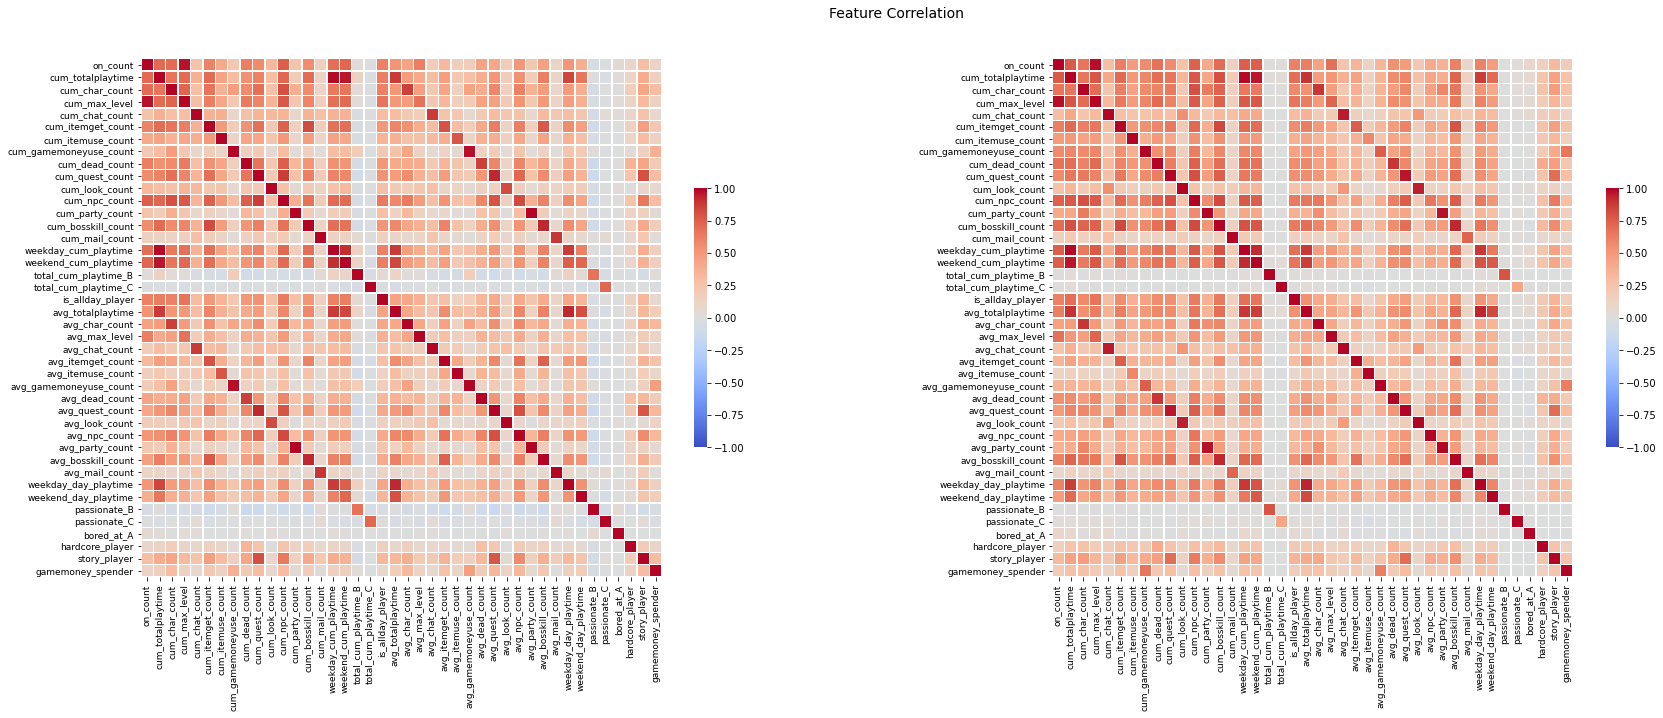

In [5]:
import seaborn as sns

plt.figure(figsize=(28, 9))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(A.loc[user_AnB,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnB,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(A.loc[user_AnC,:].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnC,:].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.suptitle("Feature Correlation", fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

# Step 2. Prediction
## 2-1. Predict label of 'Passionate player' : Classification

In [6]:
from sklearn.ensemble import RandomForestClassifier

for y_col in ['passionate_B', 'passionate_C']:
    
    if y_col == 'passionate_B':
        train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
        test = A.drop(['total_cum_playtime_B'], axis=1).copy()
        test = test.drop(user_AnB, axis=0)

    if y_col == 'passionate_C':
        train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
        test = A.drop(['total_cum_playtime_C'], axis=1).copy()
        test = test.drop(user_AnC, axis=0)
        
    sc = StandardScaler()

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)
    
    print(Counter(train_y))
    
    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    
    train_x, train_y = sm.fit_resample(train_x, train_y)
    print("Oversampled:", Counter(train_y))
    
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_x, train_y)
    pred_y = rf.predict(test_x)
    
    A.loc[test.index,y_col] = pred_y

Counter({0.0: 690, 1.0: 231})
Oversampled: Counter({1.0: 690, 0.0: 690})
Counter({0.0: 6714, 1.0: 2243})
Oversampled: Counter({1.0: 6714, 0.0: 6714})


In [7]:
# Print predicted labels
print(Counter(A['passionate_B']))
print(Counter(A['passionate_C']))

Counter({0.0: 90675, 1.0: 22733})
Counter({0.0: 72124, 1.0: 41284})


## Step 2-2. Predict probability of 'Passionate player' : Regression

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

Counter({0.0: 690, 1.0: 231})
Oversampled: Counter({1.0: 690, 0.0: 690})
Epoch 1/1000
8/8 [==============================] - 2s 55ms/step - loss: 0.2766 - val_loss: 0.6926
Epoch 2/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.2257 - val_loss: 0.5930
Epoch 3/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2087 - val_loss: 0.5446
Epoch 4/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2038 - val_loss: 0.5140
Epoch 5/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2092 - val_loss: 0.4990
Epoch 6/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.2025 - val_loss: 0.4913
Epoch 7/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1876 - val_loss: 0.4445
Epoch 8/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1961 - val_loss: 0.4502
Epoch 9/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.1960 - val_loss: 0.4649
Epoch 10/1000
8/8 [=========================

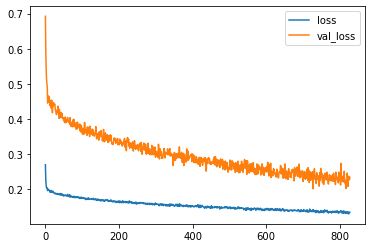

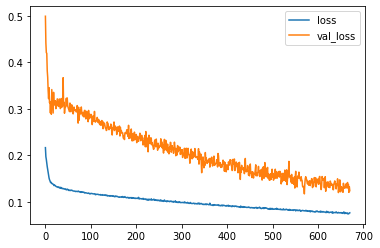

In [9]:
for y_col in ['passionate_B', 'passionate_C']:

    # extract train data: user_AnB or user_AnC data
    if y_col == 'passionate_B':
        train = A.loc[user_AnB].drop(['total_cum_playtime_B'], axis=1).copy()
        test = A.drop(['total_cum_playtime_B'], axis=1).copy()
        test = test.drop(user_AnB, axis=0)

    if y_col == 'passionate_C':
        train = A.loc[user_AnC].drop(['total_cum_playtime_C'], axis=1).copy()
        test = A.drop(['total_cum_playtime_C'], axis=1).copy()
        test = test.drop(user_AnC, axis=0)

    sc = StandardScaler()

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)

    print(Counter(train_y))

    ## Oversampling for Class-imbalanced Problem
    from imblearn.over_sampling import SMOTE 
    sm = SMOTE(random_state=42, k_neighbors=7)
    train_x, train_y = sm.fit_resample(train_x, train_y)
    print("Oversampled:", Counter(train_y))

    ## Model training with oversampled dataset
    N = train_x.shape[0]
    M = train_x.shape[1]
    train_x = train_x.reshape(N, M, 1).copy()
    
    model = Sequential()
    model.add(Conv1D(128, 8, input_shape=(M, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))

    optimizer = SGD(0.01)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
    history = model.fit(x=np.array(train_x),
                      y=np.array(train_y),
                      validation_split = 0.3,
                      batch_size=128,
                      epochs=1000,
                      callbacks=[early_stop])

    losses = pd.DataFrame(history.history)
    losses.plot()
    
    dnn = model
    
    ## Reload dataset (without smote) Fit and Predict Probability with original dataset
    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)

    N = train_x.shape[0]
    M = train_x.shape[1]
    train_x = train_x.reshape(N, M, 1).copy()

    N = test_x.shape[0]
    M = test_x.shape[1]
    test_x = test_x.reshape(N, M, 1).copy()

    prob_train = dnn.predict(train_x)
    prob_test = dnn.predict(test_x)
    
    ## Scale the prediction between 0 and 1
    msc = MinMaxScaler()
    prob_train = msc.fit_transform(prob_train)
    prob_test = msc.fit_transform(prob_test)
    
    feat_name = str("prob_"+y_col)
    A.loc[test.index, feat_name] = prob_test.reshape(len(test_x),)
    A.loc[train.index, feat_name] = prob_train.reshape(len(train_x),)


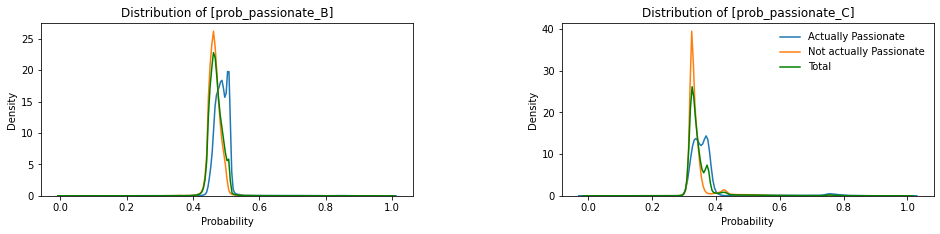

[]

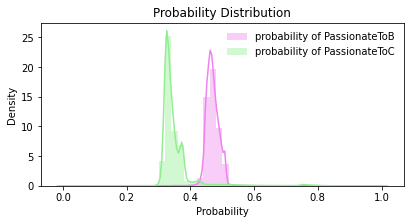

In [10]:
from scipy.stats import norm
import seaborn as sns

plt.figure(figsize=(16, 3))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
sns.distplot(A[A['passionate_B'] == 1.0]['prob_passionate_B'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_B'] != 1.0]['prob_passionate_B'], label='Not actually Passionate', hist=False)
sns.distplot(A['prob_passionate_B'], label='Total', hist=False, color='green')
plt.title("Distribution of [prob_passionate_B]")
plt.xlabel("Probability")

plt.subplot(1,2,2)
sns.distplot(A[A['passionate_C'] == 1.0]['prob_passionate_C'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_C'] != 1.0]['prob_passionate_C'], label='Not actually Passionate', hist=False)
sns.distplot(A['prob_passionate_C'], label='Total', hist=False, color='green')
plt.title("Distribution of [prob_passionate_C]")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Probability")
plt.show()

plt.figure(figsize=(6.5, 3))
sns.distplot(A['prob_passionate_B'], label='probability of PassionateToB', color='violet')
sns.distplot(A['prob_passionate_C'], label='probability of PassionateToC', color='lightgreen')
plt.legend(frameon=False, loc='upper right')
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.plot()

In [11]:
#A.to_csv(os.path.join(data_dir, 'final_A.csv'), header=True, index=True)

final_A = pd.read_csv(os.path.join(data_dir, 'final_A.csv'))
final_A.index = np.array(final_A[final_A.columns[0]])
final_A = final_A.drop([final_A.columns[0]], axis=1)

def reload_final_A():
    return final_A.replace(np.nan, 0).copy()

## 2-3. Predict 'cumulative play time' on other games: Regression

In [12]:
A = reload_final_A()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import GradientBoostingRegressor

for y_col in ['total_cum_playtime_B', 'total_cum_playtime_C']:
    
    sc = StandardScaler()
    
    if y_col == 'total_cum_playtime_B':
        train = A.loc[user_AnB].copy()
        test = A.drop(user_AnB, axis=0)
    elif y_col == 'total_cum_playtime_C':
        train = A.loc[user_AnC].copy()
        test = A.drop(user_AnC, axis=0)

    train_y = train[y_col].copy()
    train_x = train.drop([y_col], axis=1).copy()
    train_x = sc.fit_transform(train_x)

    test_x = test.drop([y_col], axis=1).copy()
    test_x = sc.fit_transform(test_x)
    
    if y_col == 'total_cum_playtime_B':
        
        # Select model: Gradient Boositing Regressor
        gdb = GradientBoostingRegressor(random_state=0, n_estimators=500)
        gdb.fit(train_x, train_y)
        pred_train = gdb.predict(train_x)
        pred_test = gdb.predict(test_x)
        
    elif y_col == 'total_cum_playtime_C':
        
        N = train_x.shape[0]
        M = train_x.shape[1]
        train_x = train_x.reshape(N, M, 1).copy()

        N = test_x.shape[0]
        M = test_x.shape[1]
        test_x = test_x.reshape(N, M, 1).copy()
        
        # Select model: CNN
        
        model = Sequential()
        model.add(Conv1D(64, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 8, input_shape=(M, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1))
        optimizer = Adam(.0001)
        model.compile(optimizer=optimizer, loss='mse')

        
        early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
        history = model.fit(x=np.array(train_x),
                          y=np.array(train_y),
                          validation_split = 0.2,
                          batch_size=512,
                          epochs=1000,
                          callbacks=[early_stop])

        losses = pd.DataFrame(history.history)

        cnn = model
        pred_train = cnn.predict(train_x)
        pred_test = cnn.predict(test_x)
    
    # processing result value: remove minus time and remove maximum monthly available time
    pred_train[pred_train < 0] = 0
    pred_test[pred_test < 0] = 0

    pred_train[pred_train > (31*24*60)] = (31*24*60)
    pred_test[pred_test > (31*24*60)] = (31*24*60)

    feat_name = str("pred_"+y_col)
    A.loc[train.index, feat_name] = pred_train.reshape(len(train_x),)
    A.loc[test.index, feat_name] = pred_test.reshape(len(test_x),)

Epoch 1/1000
14/14 [==============================] - 1s 26ms/step - loss: 1525016.8167 - val_loss: 1844094.0000
Epoch 2/1000
14/14 [==============================] - 0s 9ms/step - loss: 1480681.4750 - val_loss: 1817939.3750
Epoch 3/1000
14/14 [==============================] - 0s 9ms/step - loss: 1553499.9292 - val_loss: 1762426.6250
Epoch 4/1000
14/14 [==============================] - 0s 9ms/step - loss: 1492715.3417 - val_loss: 1746307.2500
Epoch 5/1000
14/14 [==============================] - 0s 9ms/step - loss: 1295918.9833 - val_loss: 1733384.2500
Epoch 6/1000
14/14 [==============================] - 0s 9ms/step - loss: 1455353.2708 - val_loss: 1726445.3750
Epoch 7/1000
14/14 [==============================] - 0s 9ms/step - loss: 1583892.3833 - val_loss: 1719906.3750
Epoch 8/1000
14/14 [==============================] - 0s 9ms/step - loss: 1296765.2333 - val_loss: 1711812.6250
Epoch 9/1000
14/14 [==============================] - 0s 9ms/step - loss: 1609658.3917 - val_loss: 1699

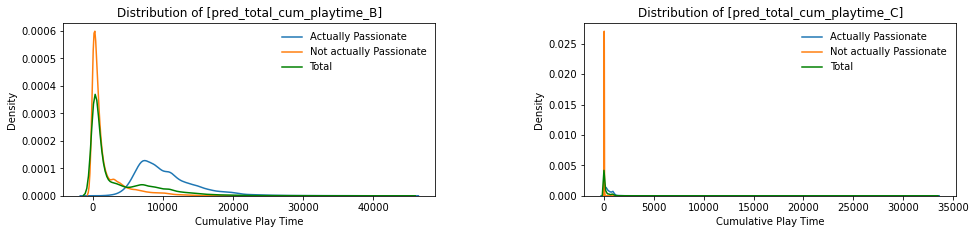

[]

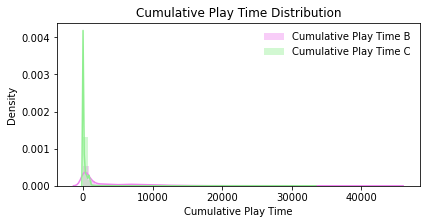

In [14]:
from scipy.stats import norm
import seaborn as sns

plt.figure(figsize=(16, 3))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(1,2,1)
sns.distplot(A[A['passionate_B'] == 1.0]['pred_total_cum_playtime_B'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_B'] != 1.0]['pred_total_cum_playtime_B'], label='Not actually Passionate', hist=False)
sns.distplot(A['pred_total_cum_playtime_B'], label='Total', hist=False, color='green')
plt.legend(frameon=False, loc='upper right')
plt.title("Distribution of [pred_total_cum_playtime_B]")
plt.xlabel("Cumulative Play Time")

plt.subplot(1,2,2)
sns.distplot(A[A['passionate_C'] == 1.0]['pred_total_cum_playtime_C'], label='Actually Passionate', hist=False)
sns.distplot(A[A['passionate_C'] != 1.0]['pred_total_cum_playtime_C'], label='Not actually Passionate', hist=False)
sns.distplot(A['pred_total_cum_playtime_C'], label='Total', hist=False, color='green')
plt.title("Distribution of [pred_total_cum_playtime_C]")
plt.legend(frameon=False, loc='upper right')
plt.xlabel("Cumulative Play Time")
plt.show()

plt.figure(figsize=(6.5, 3))
sns.distplot(A['pred_total_cum_playtime_B'], label='Cumulative Play Time B', color='violet')
sns.distplot(A['pred_total_cum_playtime_C'], label='Cumulative Play Time C', color='lightgreen')
plt.legend(frameon=False, loc='upper right')
plt.title("Cumulative Play Time Distribution")
plt.xlabel("Cumulative Play Time")
plt.plot()

In [15]:
result = A[['pred_total_cum_playtime_B', 'prob_passionate_B', 'pred_total_cum_playtime_C', 'prob_passionate_C']]
output['A게임 유저ID'] = result.index
output.iloc[:,1:] = np.array(result.iloc[:,:])

In [27]:
#output.to_csv(os.path.join(data_dir, 'output_result.csv'), header=True, index=False)

In [28]:
pd.read_csv(os.path.join(data_dir, 'output_result.csv'))

,A게임 유저ID,B게임 플레이시 한달간 누적 플레이 예측 시간(분),B게임 플레이시 열성적인 플레이어가 될 확률,C게임 플레이시 한달간 누적 플레이 예측 시간(분),C게임 플레이시 열성적인 플레이어가 될 확률
0,7ecab67cb6312774e5f2bebc06b0a25bb6ba4e05dd4288...,12377.925101,0.473743,184.939056,0.319683
1,bdd903063fca43fc241788a885546b916e140f27094235...,7195.112018,0.471931,143.602890,0.327383
2,4c7bab12c8f057a6de6d6254b57c2c6fcaf09811111ca9...,5276.498377,0.519896,275.703217,0.335807
3,3a86c0f0a5f39c77a4e01dac0e26ab64e95dd922cf3827...,8743.454057,0.508304,42.714745,0.326240
4,73bda44dfac93a85385b5d94539deee23227ccd661a2bb...,442.598116,0.476366,144.736038,0.321029
...,...,...,...,...,...
113403,73e55b62351111aaa8585b2b7084e34fcb060fc53343ff...,3705.226303,0.501368,61.388847,0.322059
113404,3f199380526a3eae95fffabecd87d67dbc91b36a99c05c...,9576.816150,0.496542,45.790024,0.419140
113405,d11a12ee980ced2135029ad62c3793a3b59fe80ca6c1f4...,1112.083354,0.469878,326.069855,0.320412
113406,91c71cafe077691b50c131aa375a8de2070faa1792c28e...,10830.474092,0.503583,39.147308,0.326593


# Appendix. Voting from Model Candidates 

## 1. Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
ab = AdaBoostClassifier(n_estimators=100)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0)
dt = DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=0)
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

clf_models = [rf, ab, gb, dt, svm]
clf_names = ['Random Forest', 'Adaboost', 'Gradient Boosting', 'Decision Tree', 'SVM']

K = 5
for model, name in zip(clf_models, clf_names):
    acc = cross_val_score(model, train_x, train_y, scoring='accuracy', cv=K)
    f1 = cross_val_score(model, train_x, train_y, scoring='f1', cv=K)
    print("Accuracy: \t\t %0.4f (+/- %0.4f) [%s]" % (acc.mean(), acc.std(), name))
    print("F1-score: \t\t %0.4f (+/- %0.4f)\n" % (f1.mean(), f1.std()))

## 2. Regression

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR

ridge = lin.RidgeCV(alphas=np.logspace(-6, 6, 13))
lasso = lin.LassoCV()
rfreg = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)
adbreg = AdaBoostRegressor(random_state=42, n_estimators=500)
gdbreg = GradientBoostingRegressor(random_state=0, n_estimators=100)

reg_models = [ridge, lasso, rfreg, adbreg, gdbreg]
reg_names = ['Ridge_CV', 
             'Lasso_CV', 
             'Random Forest Regressor', 
             'AdaBoost Regressor', 
             'Gradient Boosting Regressor']
K = 5
for model, name in zip(reg_models, reg_names):
    r2 = cross_val_score(model, train_x, train_y, scoring='r2', cv=K)
    MSE = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=K)
    RMSE = cross_val_score(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=K)
    
    print("R-square: \t\t %0.4f (+/- %0.4f) \t\t[%s]" % (r2.mean(), r2.std(), name))
    print("MSE: \t\t\t %0.4f (+/- %0.4f)" % (MSE.mean(), MSE.std()))
    print("RMSE: \t\t\t %0.4f (+/- %0.4f)\n" % (RMSE.mean(), RMSE.std()))

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(64, 8, input_shape=(M, 1)))
cnn.add(Activation('relu'))
cnn.add(Conv1D(64, 8, input_shape=(M, 1)))
cnn.add(Activation('relu'))
cnn.add(Flatten())
cnn.add(Dropout(0.5))
cnn.add(Dense(2048, activation='relu'))
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dense(1))
optimizer = Adam(.0001)
cnn.compile(optimizer=optimizer, loss='mse')